In [30]:
import pandas as pd

#names = ["chr", "start", "end", "name", "pwm", "strand", "pchr", "pstart", "pend", "tobias", "counts", "profile", "chip", "obs", "label"]
names = ["chr", "start", "end", "name", "pwm", "strand", "pchr", "pstart", "pend", "tobias", "atac_counts", "atac_profile", "dnase_counts", "dnase_profile", "chip", "atac_obs", "dnase_obs"]

cl="GM12878"
pp="pattern_1_CTCF"
bed="ENCSR000DRZ.bed"

main_dir="/mnt/lab_data2/anusri/chrombpnet/src/evaluation/figure_notebooks/figure_5/chip_seq_compare/new_output_jan_18/"
data = pd.read_csv(main_dir+cl+"/"+pp+"/"+bed, sep='\t', names=names)
data["label"] = True
data = data[data["label"]]

In [31]:
data.shape

(37754, 18)

In [32]:
import pyBigWig as pw
import numpy as np

In [33]:
observed="/oak/stanford/groups/akundaje/projects/chromatin-atlas-2022/chrombpnet/merged/"+cl+"/DNASE/"+cl+"_wo_bias.bw"


In [51]:
bw_obs = pw.open(observed)

In [52]:
observed_vals = []
for i,r in data.iterrows():
    mid = int((r[1]+r[2])/2)
    val1 = np.nan_to_num(bw_obs.values(r[0],mid-60,mid+60))
    observed_vals.append(val1)

In [53]:

observed_vals = np.array(observed_vals)


In [10]:
data.head()

,chr,start,end,name,pwm,strand,pchr,pstart,pend,tobias,atac_counts,atac_profile,dnase_counts,dnase_profile,chip,atac_obs,dnase_obs,label
0,chr1,959149,959159,pos_patterns.pattern_10.REL_MA0101.1_pos_patte...,9.80133,-,chr1,958780,959739,0.35081,-0.014227,0.004619,0.014226,-0.000992,0.056056,1531.0,108.0,True
1,chr1,1013138,1013148,pos_patterns.pattern_10.REL_MA0101.1_pos_patte...,7.52757,+,chr1,1012902,1014648,0.10750,-0.024160,-0.001543,-0.023115,0.001625,0.022299,764.0,73.0,True
2,chr1,1058962,1058972,pos_patterns.pattern_10.REL_MA0101.1_pos_patte...,10.48439,-,chr1,1058360,1059953,0.54271,0.059963,-0.005274,0.069396,-0.009182,0.119999,1118.0,38.0,True
3,chr1,1064590,1064600,pos_patterns.pattern_10.REL_MA0101.1_pos_patte...,8.06570,-,chr1,1063665,1064824,0.24763,-0.011777,0.004872,0.004442,0.003285,0.042082,1357.0,90.0,True
4,chr1,1137512,1137522,pos_patterns.pattern_10.REL_MA0101.1_pos_patte...,7.39504,+,chr1,1136299,1138133,0.74912,0.388687,0.022580,0.280941,0.010240,0.288400,1848.0,49.0,True


In [17]:
import numpy as np

def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))


In [12]:
import seaborn as sns

In [13]:
cmap = sns.color_palette(['#109648', '#255C99', '#F7B32B', '#D62839']) 
cmap

[(0.06274509803921569, 0.5882352941176471, 0.2823529411764706),
 (0.1450980392156863, 0.3607843137254902, 0.6),
 (0.9686274509803922, 0.7019607843137254, 0.16862745098039217),
 (0.8392156862745098, 0.1568627450980392, 0.2235294117647059)]

In [15]:
import pyfaidx

In [34]:
genome="/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
hg38 = pyfaidx.Fasta(genome)

In [35]:
observed_seqgs = []
for i,r in data.iterrows():
    mid = int((r[1]+r[2])/2)
    val1 = str(hg38[r[0]][r[1]:r[2]])
    observed_seqgs.append(val1)

In [36]:
one_hots = dna_to_one_hot(observed_seqgs)

In [37]:
one_hots.shape

(37754, 14, 4)

In [38]:
np.argmax(one_hots,-1).shape

(37754, 14)

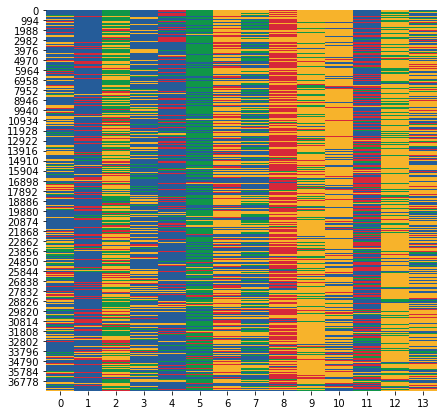

In [46]:
f, ax = plt.subplots(figsize=(7,7))
index=np.argsort(data["atac_profile"].values)[::-1][:data["atac_profile"].shape[0]]
cur = sns.heatmap(np.argmax(one_hots[index],-1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax,
                 cbar=0)

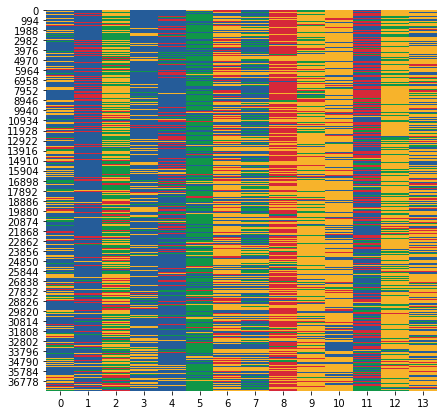

In [44]:
f, ax = plt.subplots(figsize=(7,7))
index=np.argsort(data["dnase_counts"].values)[::-1][:data["dnase_counts"].shape[0]]
cur = sns.heatmap(np.argmax(one_hots[index],-1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax,
                 cbar=0)

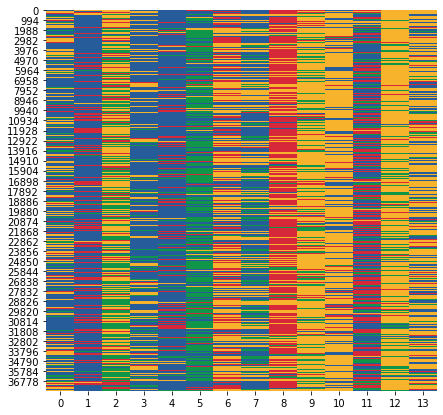

In [47]:
f, ax = plt.subplots(figsize=(7,7))
index=np.argsort(data["tobias"].values)[::-1][:data["tobias"].shape[0]]
cur = sns.heatmap(np.argmax(one_hots[index],-1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax,
                 cbar=0)

In [80]:
observed_vals.shape

(37754, 120)

In [81]:
observed_vals = []
for i,r in data.iterrows():
    mid = int((r[1]+r[2])/2)
    val1 = np.nan_to_num(bw_obs.values(r[0],mid-60,mid+60))
    observed_vals.append(val1/np.sum(val1))

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [84]:
observed_vals = np.array(observed_vals)
index=np.argsort(data["tobias"].values)[::-1][:data["tobias"].shape[0]]
ndd = observed_vals[index]
ndd2 = np.mean(np.lib.stride_tricks.sliding_window_view(ndd,wn,axis=0)[0::wn],axis=-1)
index=np.argsort(data["atac_counts"].values)[::-1][:data["atac_counts"].shape[0]]
ndd = observed_vals[index]
ndd3 = np.mean(np.lib.stride_tricks.sliding_window_view(ndd,wn,axis=0)[0::wn],axis=-1)
index=np.argsort(data["chip"].values)[::-1][:data["chip"].shape[0]]
ndd = observed_vals[index]
ndd4 = np.mean(np.lib.stride_tricks.sliding_window_view(ndd,wn,axis=0)[0::wn],axis=-1)


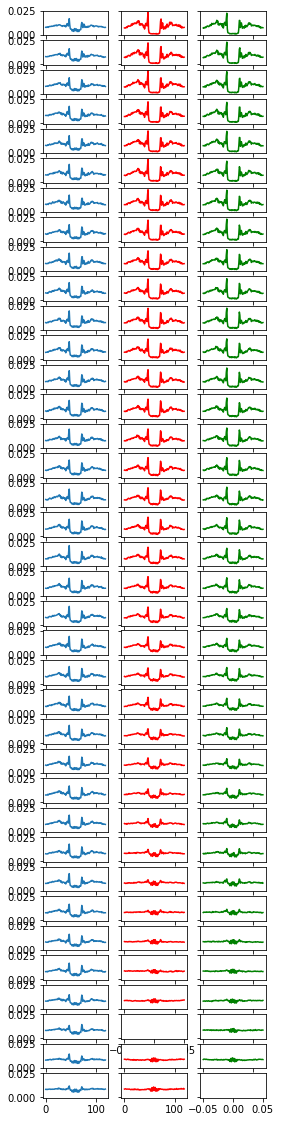

In [85]:
f, ax = plt.subplots(nrows=37, ncols=3,figsize=(4,20), sharey=True)
for i in range(37):
    ax[i,0].plot(ndd2[i])
    ax[i,1].plot(ndd3[i], color="red")
    ax[i,2].plot(ndd4[i], color="green")

In [55]:
ndd.shape

(37754, 120)

In [63]:
 np.lib.stride_tricks.sliding_window_view(ndd,1000,axis=0).shape

(36755, 120, 1000)

(37, 120)

(6,)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

array([[0, 1, 2],
       [3, 4, 5]])

In [ ]:
observed_vals 

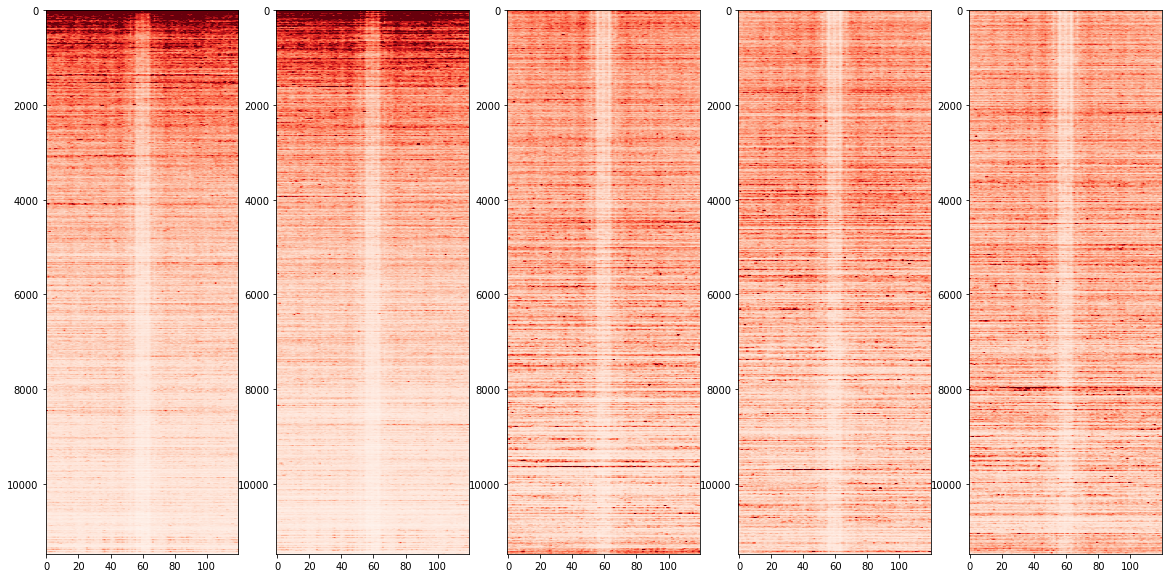

In [11]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#no_signals=len(cwm_values)
fig,ax = plt.subplots(1,5 ,figsize = (20, 10), gridspec_kw={'width_ratios': [4, 4,  4, 4, 4]})

maxv = np.max(observed_vals)

vmin, vmax = np.percentile(observed_vals, [5, 95])

index=np.argsort(data["atac_obs"].values)[::-1][:data["atac_obs"].shape[0]]
im1 = ax[0].imshow(observed_vals[index],cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

index=np.argsort(data["tobias"].values)[::-1][:data["tobias"].shape[0]]
im1 = ax[1].imshow(observed_vals[index],cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

index=np.argsort(data["atac_counts"].values)[::-1][:data["atac_counts"].shape[0]]
im1 = ax[2].imshow(observed_vals[index],cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

index=np.argsort(data["atac_profile"].values)[::-1][:data["atac_profile"].shape[0]]
im1 = ax[3].imshow(observed_vals[index],cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

index=np.argsort(data["chip"].values)[::-1][:data["chip"].shape[0]]
im1 = ax[4].imshow(observed_vals[index],cmap="Reds",aspect="auto",norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))

#plt.savefig("ctcf_hepg_occupancy_plot.pdf", dpi=300, transparent=True)

